# Amazon Food Reviews - [Logistic Regression]

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

## Excerpt 
1. Applied Logistic Regression on Different Featurization of Data viz. BOW(uni-gram,bi-gram), tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec <br>
2. Used both Grid Search & Randomized Search Cross Validation <br>
3. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix using seaborne<br>
4. Showed How Sparsity increases as we increase lambda or decrease C when L1 Regularizer is used for each featurization<br>
5. Did pertubation test to check whether the features are multi-collinear or not

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)


### Objective:- Review Polarity
Given a review, determine the review is positive or negative

#### Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [2]:
# !pip install --upgrade pip
# !pip install qtconsole ipywidgets widgetsnbextension
# !pip install seaborn
# !pip install nltk
# # import nltk
# # nltk.download("stopwords")
# !pip install gensim

In [3]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [16]:
# !wget --header="Host: e-2106e5ff6b.cognitiveclass.ai" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.1009651095.1527270727; _xsrf=2|d66eb8d7|8e30b1015ec501038d0632ff567bddb6|1529904261; session=.eJxVj9tugkAURX_FnGdi5FaBxKSgoiZKtYq0Ng0ZYIBRGBQGEY3_XjBt2r6us1f2PjdwjzhPEcWUgcbyEnOASha7LDtgCtoNOg3_gBoJaneSiIVh7x0UXf0wWsTyNNkZorCZKbm5Z6ZAgrAotpbZz3aC4fRn0vyqWFYujKlOp97YWF963kVdE10I-KoKzFLE7OS9rtUzNmRnPlrOlq6a6Updnh00TspafjLEGJ18aSjtfRu4Zo0HGsD9885BgRL2GNiilX18tye70-LNXLw4puw7vLzaWrWdxCN701OH0WAAjVQWOHcJDbPWxCkiSSPnxD_UKCCs-bLP889Ry7t-lgIHIckL5lKU4iaoPzINTdAvnJRH1rJ_mc4PbQu_L39r2i2V55IANEWWROn-BWX4gJ4.Dh00Fg.mP7VsxA46qaQLe4cyW_hdiRguhw" --header="Connection: keep-alive" "https://e-2106e5ff6b.cognitiveclass.ai/files/Amazon%20Fine%20Food%20Reviews%20Dataset/GoogleNews-vectors-negative300.bin?download=1" -O "GoogleNews-vectors-negative300.bin" -c

--2018-07-07 00:02:23--  https://e-2106e5ff6b.cognitiveclass.ai/files/Amazon%20Fine%20Food%20Reviews%20Dataset/GoogleNews-vectors-negative300.bin?download=1
Resolving e-2106e5ff6b.cognitiveclass.ai (e-2106e5ff6b.cognitiveclass.ai)... 169.53.184.237, 169.55.145.204
Connecting to e-2106e5ff6b.cognitiveclass.ai (e-2106e5ff6b.cognitiveclass.ai)|169.53.184.237|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



### Loading the data

In [146]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [7]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [8]:
df.shape
df['Score'].size

364171

## For EDA and Text Preprecessing Refer other ipynb notebook<b>

In [9]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [10]:
#Taking Sample Data
n_samples = 50000
df_sample = df.sample(n_samples)

###Sorting as we want according to time series
df_sample.sort_values('Time',inplace=True) 
df_sample.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b'witty little book makes son laugh loud recit...
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,0,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...,b'remember seeing show aired television years ...
298792,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,0,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...,b'beetlejuice well written movie everything ex...
298791,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,0,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...,b'beetlejuice excellent funny movie keaton hil...
169342,212533,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,0,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...,b'one movie movie collection filled comedy act...
169320,212511,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,0,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazyim look beatlejuic french version v...,b'getting crazyim looking beatlejuice french v...
169366,212557,230375,B00004RYGX,A3K3YJWV0N54ZO,Joey,2,3,0,1001289600,"Beetlejuice is a greatmovie, but they cheated ...",Just to warn you. when in trying to trick you ...,b'warn tri trick widescreen format compani mad...,b'warn trying trick widescreen format company ...
169303,212494,230308,B00004RYGX,A3C3BAQDZWH5YE,Kushana no shinryaku (Kushana's invasion),0,1,0,1014681600,...,"It was on the other night, and, having been a ...",b'night big fan cartoon shown decid watch also...,b'night big fan cartoon shown decided watch al...
117349,138016,149787,B00004S1C6,A2XZKD83G4N9Y5,Cindy Elliott,43,45,0,1036454400,Great!,"For those wondering, the bottles are each 3/4 ...",b'wonder bottl gel food color vibrant amount g...,b'wondering bottles gel food color vibrant amo...
117266,137933,149701,B00006L2ZT,A2STZ646VQE8QI,anomalogue,1,3,0,1036540800,This is the best Camper Van Beethoven,This is a beautiful repackaging of Camper Van...,b'beauti repackag camper van beethoven first t...,b'beautiful repackaging camper van beethovens ...


In [11]:
#Saving 50000 samples in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_lr")

In [4]:
#Opening from samples from file
df_sample = openfromfile("sample_lr")

# Logistic Regression Model on Reviews using Different Vectorizing Techniques in NLP

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [209]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 42387)
Test Data Size:  (15000, 42387)


Observed that Data Normalization gives better accuracy rather than Data Standardization. <br>
Hence used Data Normalization

In [52]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(3190, 42387) (3181, 42387)
(6371, 42387) (3181, 42387)
(9552, 42387) (3181, 42387)
(12733, 42387) (3181, 42387)
(15914, 42387) (3181, 42387)
(19095, 42387) (3181, 42387)
(22276, 42387) (3181, 42387)
(25457, 42387) (3181, 42387)
(28638, 42387) (3181, 42387)
(31819, 42387) (3181, 42387)


![image.png](attachment:image.png)

### Finding the best "C" or "1/lambda" and regularizer [ L1 or L2 ] using Forward Chaining Cross Validation or Time Series CV 

On Whole Dataset

In [13]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 201.6min finished


Best HyperParameter:  {'C': 0.05, 'penalty': 'l1'}
Best Accuracy: 91.37%


<b>Note:As it took long hours for training on whole dataset, did modelling on sample 50000 points</b> 

On 50K points

In [7]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.5min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 90.94%


<b>With 'C': 10 & 'penalty': 'l2' uni_gram has the highest accuracy of 90.94% in Cross Validation<b>

Accuracy on test set: 90.527%
Precision on test set: 0.804
Recall on test set: 0.621
F1-Score on test set: 0.700
Non Zero weights: 42387
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



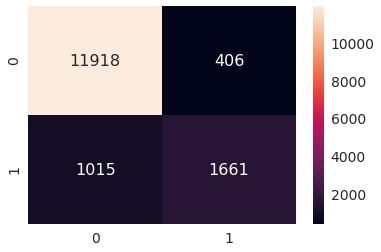

In [54]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 86.487%
F1-Score on test set: 0.623
Non Zero weights: 7244


In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.107%
F1-Score on test set: 0.657
Non Zero weights: 6599


In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.100%
F1-Score on test set: 0.699
Non Zero weights: 3690


In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.247%
F1-Score on test set: 0.681
Non Zero weights: 700


In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 86.087%
F1-Score on test set: 0.417
Non Zero weights: 101


In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.173%
F1-Score on test set: 0.001
Non Zero weights: 3


<b> We can see how drastically the sparsity increases from 7244 non-zero weights(@ C=1000) to only 3 non-zero weights(@ C=0.01) when we use L1 Regularization</b>

#### Using Randomized Search CV to find best parameters

In [16]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 5}
Best Accuracy: 90.74%


Accuracy on test set: 90.433%
Precision on test set: 0.809
Recall on test set: 0.607
F1-Score on test set: 0.693
Non Zero weights: 42387
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



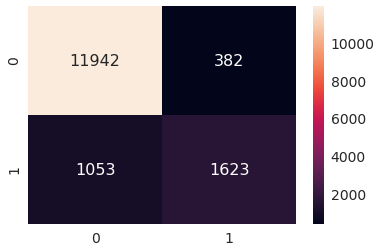

In [18]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Perturbation Test

In [210]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.527%
Non Zero weights: 42387


In [211]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[-1.89730274e-01 -3.15372263e-02 -6.76179169e-02 -5.11515825e-02
 -2.46214429e-02 -1.44501314e-02 -2.72618635e-01 -2.70065305e-01
 -6.28786581e-03 -6.11281646e-03 -9.66713082e-02  3.86776364e-01
  5.10933235e-01 -7.79666695e-03  1.21828724e-01  2.10066534e-01
  5.66267795e-01  1.24596872e-01 -2.44259460e-01 -1.32921619e-01
  1.70863867e-01 -1.16295181e-01 -5.53461924e-04  7.05172041e-02
  3.58983574e-02 -1.27481892e-01 -1.86824715e+00 -2.12679597e-02
 -6.81274598e-03 -2.29483656e-03 -8.37846437e-01 -8.11102012e-02
 -5.03645443e-02  2.04508909e+00  7.34631489e-01 -1.34789365e-01
 -1.04276355e-01 -1.43209680e-01 -2.29996110e-02 -2.41604628e-03
 -8.67516315e-03 -1.97463221e-01  1.07459896e-01 -3.35453349e-02
 -7.77627187e-03 -5.93428253e-03  3.20286868e-02  6.30952106e-01
 -8.58717575e-01  5.61936901e-01]


In [213]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [214]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.533%
Non Zero weights: 42387


In [215]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[-1.89950968e-01 -3.16337282e-02 -6.77317107e-02 -5.14557246e-02
 -2.46485012e-02 -1.45444516e-02 -2.72725882e-01 -2.70411219e-01
 -6.30040600e-03 -6.14559790e-03 -9.70617160e-02  3.86567619e-01
  5.10745146e-01 -7.79650378e-03  1.21740390e-01  2.10257183e-01
  5.66312396e-01  1.24363187e-01 -2.43903726e-01 -1.33243048e-01
  1.69985119e-01 -1.16127064e-01 -5.54595155e-04  7.05977955e-02
  3.59816819e-02 -1.27319420e-01 -1.86985598e+00 -2.13052554e-02
 -6.78135230e-03 -2.31172184e-03 -8.36409663e-01 -8.07220024e-02
 -5.04655554e-02  2.04163986e+00  7.34509011e-01 -1.34830819e-01
 -1.03999990e-01 -1.43578978e-01 -2.30018789e-02 -2.42712664e-03
 -8.71110442e-03 -1.97894906e-01  1.07495595e-01 -3.35448984e-02
 -7.77044764e-03 -5.91318255e-03  3.20063922e-02  6.30819931e-01
 -8.56312263e-01  5.60739271e-01]


In [216]:
print(weights2.size)

42387


In [217]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [218]:
print(weights_diff[np.where(weights_diff > 30)].size)

7


 <b>7 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

#### Feature Importance[Top 25]

##### The coef_ attribute of MultinomialNB is a re-parameterization of the naive Bayes model as a linear classifier model. For a binary classification problems this is basically the log of the estimated probability of a feature given the positive class. It means that higher values mean more important features for the positive class.

In [36]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(uni_gram,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-9.4336	delici         				16.1592	worst          
	-9.0718	amaz           				11.6414	horribl        
	-8.6047	perfect        				10.6778	aw             
	-8.4199	awesom         				10.2086	bland          
	-7.9709	excel          				9.9958	disgust        
	-7.6686	worri          				9.7113	threw          
	-7.4284	best           				9.6797	rip            
	-7.4061	addict         				9.5185	weak           
	-7.2919	complaint      				9.1535	terribl        
	-7.0809	beat           				8.4418	unfortun       
	-6.9148	great          				8.2694	tasteless      
	-6.6750	fantast        				8.0384	sad            
	-6.5800	thank          				7.8580	cancel         
	-6.1000	hook           				7.6008	return         
	-5.8641	easi           				7.4167	disappoint     
	-5.8585	happi          				7.1576	wors           
	-5.8395	satisfi        				6.7185	gross          
	-5.69

### bi-gram

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 644387)
Test Data Size:  (15000, 644387)


In [75]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(3190, 644387) (3181, 644387)
(6371, 644387) (3181, 644387)
(9552, 644387) (3181, 644387)
(12733, 644387) (3181, 644387)
(15914, 644387) (3181, 644387)
(19095, 644387) (3181, 644387)
(22276, 644387) (3181, 644387)
(25457, 644387) (3181, 644387)
(28638, 644387) (3181, 644387)
(31819, 644387) (3181, 644387)


In [72]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.8 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.8min finished


Best HyperParameter:  {'C': 1000, 'penalty': 'l2'}
Best Accuracy: 91.52%


Accuracy on test set: 91.833%
Precision on test set: 0.835
Recall on test set: 0.676
F1-Score on test set: 0.747
Non Zero weights: 644387
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



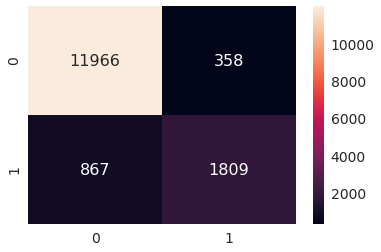

In [76]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [77]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.140%
F1-Score on test set: 0.737
Non Zero weights: 8823


In [78]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.007%
F1-Score on test set: 0.734
Non Zero weights: 6708


In [79]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.347%
F1-Score on test set: 0.740
Non Zero weights: 4477


In [80]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.900%
F1-Score on test set: 0.706
Non Zero weights: 603


In [81]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.560%
F1-Score on test set: 0.381
Non Zero weights: 77


In [82]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.160%
F1-Score on test set: 0.000
Non Zero weights: 3


<b> We can see how drastically the sparsity increases from 8823 non-zero weights(@ C=1000) to only 3 non-zero weights(@ C=0.01) when we use L1 Regularization</b>

#### Using Randomized Search CV to find best parameters

In [73]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.2min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 500}
Best Accuracy: 91.49%


Accuracy on test set: 91.773%
Precision on test set: 0.834
Recall on test set: 0.672
F1-Score on test set: 0.745
Non Zero weights: 644387
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



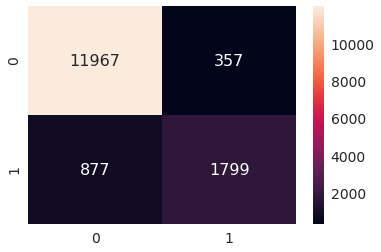

In [83]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Perturbation Test

In [84]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.773%
Non Zero weights: 644387


In [85]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[-4.97137908e-01 -4.97137908e-01 -5.84217060e-02 -5.84217060e-02
 -1.23929100e-01 -1.23929100e-01  4.38441778e-02 -1.07166825e-03
  3.30453714e-01 -1.07166825e-03 -6.83411769e-03 -7.17536471e-02
 -2.05878435e-01 -4.69698002e-02 -4.69698002e-02 -3.84751260e-02
 -3.15771985e-01 -2.56049922e-01 -4.12238618e-02 -1.84982012e-02
 -4.55092965e-01 -4.55092965e-01 -1.21459045e-02 -1.21459045e-02
 -4.34096846e-03 -2.86503408e-03 -1.47593438e-03 -3.44149642e-01
 -6.47980593e-04 -7.66443512e-03 -1.50013237e-02 -1.24062532e-02
 -3.08429649e-01  1.22563290e-01 -1.81367585e-01 -3.54951001e-03
 -9.13721821e-02  1.11686996e+00 -4.06404172e-01  2.02162972e-01
 -4.28554124e-01 -2.13171351e-04 -7.32671914e-02 -1.17417101e-02
  8.75326096e-01  8.75326096e-01 -4.30193168e-03 -4.30193168e-03
  2.61906723e-01 -2.45669888e-03]


In [87]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [88]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.633%
Non Zero weights: 644387


In [89]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[-1.24145710e-01 -1.24113896e-01 -3.21139353e-02 -3.20662337e-02
 -3.33904342e-02 -3.33695076e-02 -1.50775005e-02 -1.70652188e-03
  8.64015215e-02 -1.71544595e-03 -8.53974448e-03 -2.75940246e-02
 -6.28770794e-02 -1.95490165e-02 -1.95445236e-02 -2.31152193e-02
 -1.08878715e-01 -6.81260871e-02 -2.92657195e-02 -1.14572486e-02
 -1.12921661e-01 -1.12783705e-01 -9.94567724e-03 -9.95208209e-03
 -6.52260869e-03 -4.09800739e-03 -2.41567910e-03 -1.21254219e-01
 -1.06524044e-03 -1.15698582e-02 -1.24045561e-02 -6.52658745e-03
 -8.97176912e-02  8.33475329e-02 -7.22822623e-02 -3.81675413e-03
 -2.54951492e-02  3.70323277e-01 -8.04004336e-02  6.36101115e-02
 -1.17695636e-01 -1.45649578e-04 -4.31346004e-02 -7.93194596e-03
  2.83539371e-01  2.83508388e-01 -3.89563011e-03 -3.88617672e-03
  9.82629918e-02 -3.28661806e-03]


In [90]:
print(weights2.size)

644387


In [91]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [92]:
print(weights_diff[np.where(weights_diff > 30)].size)

429828


 <b>429828 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

#### Feature Importance[Top 25]

In [93]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bi_gram,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-10.9352	delici         				15.1738	worst          
	-10.3282	not disappoint 				11.7104	horribl        
	-10.0780	perfect        				11.1874	aw             
	-8.7928	amaz           				10.9359	disappoint     
	-8.6609	excel          				10.8218	bland          
	-8.6511	best           				9.9192	terribl        
	-8.4428	great          				9.5863	weak           
	-7.8331	awesom         				9.2938	not worth      
	-7.8283	high recommend 				9.1916	not good       
	-7.3019	happi          				9.0991	unfortun       
	-7.1258	thank          				8.8704	threw          
	-6.9936	wont disappoint				8.7462	disgust        
	-6.9529	addict         				8.7388	rip            
	-6.8050	easi           				8.3193	return         
	-6.7481	nice           				7.9911	wont buy       
	-6.7082	not bad        				7.6422	stale          
	-6.6801	favorit        				7.6007	tasteless      
	-

# tf-idf


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [94]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 644387)
Test Data Size:  (15000, 644387)
CPU times: user 8.26 s, sys: 8 ms, total: 8.27 s
Wall time: 8.26 s


In [42]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.8min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l1'}
Best Accuracy: 91.41%


Accuracy on test set: 91.727%
Precision on test set: 0.813
Recall on test set: 0.697
F1-Score on test set: 0.750
Non Zero weights: 3191
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



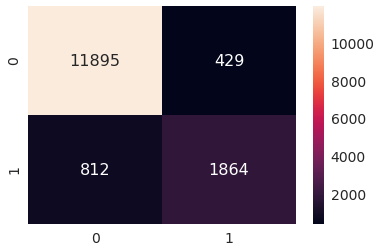

In [115]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [99]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.533%
F1-Score on test set: 0.747
Non Zero weights: 10783


In [100]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.427%
F1-Score on test set: 0.747
Non Zero weights: 7808


In [101]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.667%
F1-Score on test set: 0.751
Non Zero weights: 5296


In [102]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.920%
F1-Score on test set: 0.706
Non Zero weights: 531


In [103]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.220%
F1-Score on test set: 0.250
Non Zero weights: 34


In [104]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.160%
F1-Score on test set: 0.000
Non Zero weights: 0


<b> We can see how drastically the sparsity increases from 10783 non-zero weights(@ C=1000) to only 0 non-zero weights(@ C=0.01) when we use L1 Regularization</b>

#### Using Randomized Search CV to find best parameters

In [43]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 5}
Best Accuracy: 91.41%


Accuracy on test set: 91.727%
Precision on test set: 0.813
Recall on test set: 0.697
F1-Score on test set: 0.750
Non Zero weights: 3209
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



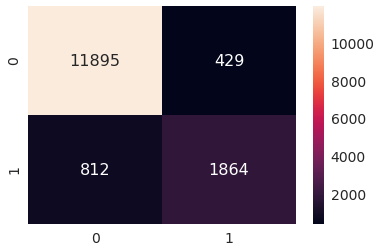

In [98]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Perturbation Test

In [105]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.853%
Non Zero weights: 644387


In [106]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[-5.14122398e-01 -5.14122398e-01 -9.70979989e-02 -9.70979989e-02
 -1.49996430e-01 -1.49996430e-01 -2.54716375e-02 -2.81286695e-03
  2.94969888e-01 -2.81286695e-03 -1.28112759e-02 -1.27011618e-01
 -1.77886329e-01 -7.62921898e-02 -7.62921898e-02 -8.65406018e-02
 -4.15353324e-01 -3.35605681e-01 -7.92290143e-02 -2.90891981e-02
 -3.65625868e-01 -3.65625868e-01 -5.61273312e-02 -5.61273312e-02
 -1.16026156e-02 -8.70806203e-03 -3.34845356e-03 -3.31971561e-01
 -2.91935816e-03 -2.54206697e-02 -1.99292204e-02 -2.03068214e-02
 -3.01105552e-01  5.48047177e-02 -2.24344061e-01 -1.01005419e-02
 -1.18044621e-01  1.10187686e+00 -3.97504572e-01  2.95661236e-01
 -3.67844617e-01 -1.07900513e-03 -1.71205297e-01 -1.99941656e-02
  8.10552718e-01  8.10552718e-01 -1.04237166e-02 -1.04237166e-02
  4.33917837e-01 -1.63892098e-02]


In [107]:
print(weights1[weights1<=0.0001])

[-0.5141224  -0.5141224  -0.097098   ... -0.26021552 -0.01791669
 -0.01791669]


In [108]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [109]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.520%
Non Zero weights: 644387


In [110]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[-0.15587652 -0.15597608 -0.04543422 -0.04543933 -0.04754008 -0.0475538
 -0.0250883  -0.00373324  0.09970389 -0.00373599 -0.01280653 -0.04623585
 -0.06115771 -0.03279188 -0.03277948 -0.04007195 -0.14799953 -0.10177153
 -0.04003041 -0.01644891 -0.10673    -0.1067302  -0.03420053 -0.03419896
 -0.01520742 -0.01038264 -0.00541653 -0.13845381 -0.00472608 -0.02809518
 -0.01766471 -0.00828539 -0.09539501  0.05081769 -0.0779084  -0.00799419
 -0.04140253  0.40861503 -0.11099605  0.10783114 -0.11704848 -0.00118688
 -0.078718   -0.01259025  0.28945277  0.28964156 -0.00692778 -0.00691456
  0.16440902 -0.01437935]


In [111]:
print(weights2.size)

644387


In [112]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [113]:
print(weights_diff[np.where(weights_diff > 30)].size)

466374


 <b>466374 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

#### Feature Importance[Top 25]

In [116]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-37.4914	not disappoint 				34.9910	worst          
	-30.1751	great          				33.2723	two star       
	-28.4580	delici         				25.0295	disappoint     
	-23.6620	wont disappoint				24.0939	horribl        
	-23.2881	perfect        				22.8940	aw             
	-22.7462	best           				22.8809	not worth      
	-22.1884	excel          				22.4072	wont buy       
	-22.1436	amaz           				21.5545	conglomer      
	-22.0387	love           				21.4801	avail cup      
	-20.3228	month would    				21.1732	threw          
	-19.5629	awesom         				20.7827	bland          
	-19.0868	high recommend 				19.7006	disgust        
	-18.0942	good           				19.6385	terribl        
	-17.6643	happi          				19.2560	almond still   
	-17.1094	complaint      				19.0726	though purchas 
	-17.0805	thank          				19.0681	deceiv         
	-16.8376	beat           				

## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [44]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [45]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

3000000

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [117]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in df_sample['CleanedText_NoStem']:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

CPU times: user 27.2 s, sys: 32 ms, total: 27.2 s
Wall time: 27.2 s


In [118]:
np.isnan(avg_vec_google).any()

False

In [119]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = df_sample['Score'][mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(50000, 300)
(50000,)


In [120]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#Normalizing the data
avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new.values,test_size=0.3,shuffle=False)

In [121]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 15.8min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 89.64%


Accuracy on test set: 88.660%
Precision on test set: 0.767
Recall on test set: 0.524
F1-Score on test set: 0.622
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



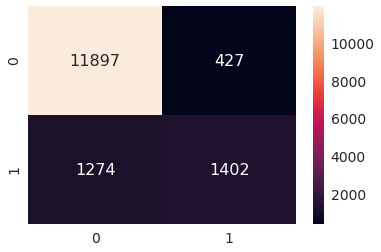

In [123]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Using Randomized Search CV to find best parameters

In [122]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.3min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 89.64%


Accuracy on test set: 88.660%
Precision on test set: 0.767
Recall on test set: 0.524
F1-Score on test set: 0.622
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



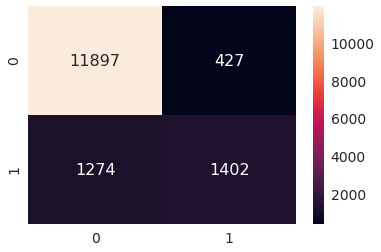

In [124]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Perturbation Test

In [134]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.660%
Non Zero weights: 300


In [135]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 4.26258629  0.12098269  7.08844436 -0.66706394 -3.22213119  0.83932454
 -1.06249836  0.33011011  0.31650731 -2.80676608  1.67766647 -2.10591555
 -1.97793342 -0.09013749 -1.51676614 -0.34577354 -0.25145424 -2.42067655
  0.15327152 -2.97624974 -0.99996899  5.10614554 -1.12699447 -2.44507472
  2.16794255  3.1501575   5.0282679   1.99578758  2.01132991 -0.14984294
 -0.49635989  1.92559871 -4.8872274  -2.94824343 -1.92820132  0.52873409
  0.75546695  3.78588235 -3.81553643 -0.92564545  0.40446639  4.31123745
  2.14691015 -6.52091446  0.65664225 -5.73615881 -2.12450831  1.62496885
 -3.75560091 -1.23236102]


In [137]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [138]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.607%
Non Zero weights: 300


In [139]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 4.00111359  0.27079926  6.90660173 -0.55721335 -2.78309505  0.84890116
 -0.84329924  0.66282238  0.76578684 -2.29616506  1.79098079 -2.0569662
 -1.70449602 -0.55047652 -1.36573252 -0.05028414 -0.73236221 -1.81448173
  0.20120897 -3.23117731 -0.73259299  4.50730526 -1.02399772 -2.495684
  2.76067807  2.96094362  5.07062685  1.44240433  1.98217538  0.23770079
 -1.02771496  1.99046737 -4.62283693 -3.04400302 -1.16898487  0.42481391
  0.27535089  3.5393455  -3.48742961 -1.0945706   0.28104383  3.80372019
  2.26410205 -6.28802575  0.60257142 -5.42097132 -1.89090069  1.59199664
 -3.69643383 -1.13076167]


In [140]:
print(weights2.size)

300


In [141]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [142]:
print(weights_diff[np.where(weights_diff > 30)].size)

41


 <b>41 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [220]:
%%time
###tf-idf with No Stemming
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.sparse import vstack

#Taking sample of only 25k points as it takes a huge amount of time ot compute 
n_samples = 25000
df_sample_new = df_sample.sample(n_samples)
X_train, X_test, y_train, y_test = train_test_split(df_sample_new['CleanedText_NoStem'].values,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
tfidf_vec_train = tfidf.fit_transform(X_train)
tfidf_vec_test = tfidf.transform(X_test)
print(tfidf_vec_train.shape)
print(tfidf_vec_test.shape)

#Concatenating sparse matrix vertically
tfidf_vec_new = vstack((tfidf_vec_train,tfidf_vec_test))
print(tfidf_vec.shape)
features = tfidf.get_feature_names()

In [219]:
savetofile(df_sample_new,"df_sample_new_tfidfw2vec")

In [179]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in df_sample_new['CleanedText_NoStem'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_new[review,features.index(word)])
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
#             print(review)
            pass
    sent_vec /= weighted_sum
#     print(sent_vec)
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

CPU times: user 4h 22min 47s, sys: 1.29 s, total: 4h 22min 48s
Wall time: 4h 22min 50s


In [180]:
#Precomputed File
tfidf_w2v_vec_google = openfromfile("tfidf_w2v_vec_google")

In [181]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

In [182]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  5.4min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 87.74%


Accuracy on test set: 88.027%
Precision on test set: 0.718
Recall on test set: 0.426
F1-Score on test set: 0.535
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



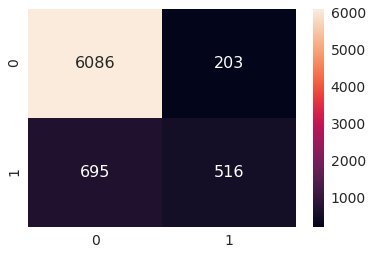

In [184]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Using Randomized Search CV to find best parameters

In [185]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 5}
Best Accuracy: 87.62%


Accuracy on test set: 88.107%
Precision on test set: 0.730
Recall on test set: 0.418
F1-Score on test set: 0.532
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



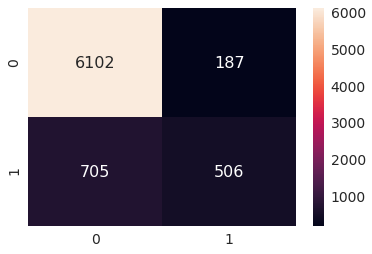

In [196]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Perturbation Test

In [197]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.107%
Non Zero weights: 300


In [198]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 3.10151061  1.72523901  4.18887132  0.16375073 -2.51851256  0.97308008
  0.08162623  0.23531025  0.73570135 -1.95731002 -0.60585601 -1.26774866
 -2.10732433 -0.36280815 -0.61587658  0.52346719  1.65458894 -0.58372329
 -1.79489363 -2.15776457 -2.16090352  4.11836729 -1.37524263 -1.10998323
  2.02729197  2.75404629  2.49513363  1.75112354  1.55761229  1.71715067
  0.08938148  0.36730124 -4.24163495 -3.39895827 -0.88316211 -0.69113141
  1.0457133   1.93014494 -2.48846581 -2.15743005 -1.41559517  2.29019006
  2.10964695 -4.81383609  1.61361531 -4.61094159 -1.5392353   1.08822612
 -2.10770816 -0.45117846]


In [199]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [200]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.027%
Non Zero weights: 300


In [201]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 3.32863502e+00  1.91410599e+00  4.46057983e+00  3.22382231e-01
 -2.66805069e+00  9.30998893e-01 -2.68977922e-03  2.85652005e-01
  6.59404102e-01 -2.31390370e+00 -6.10943686e-01 -1.31754148e+00
 -2.27255672e+00 -4.20454187e-01 -6.27159405e-01  5.64817159e-01
  1.87802167e+00 -5.28205249e-01 -2.12069729e+00 -2.37449021e+00
 -2.42989600e+00  4.65303452e+00 -1.50391502e+00 -1.02257257e+00
  2.19813852e+00  3.16556827e+00  2.43228981e+00  2.20407793e+00
  1.67229306e+00  1.89214118e+00  1.13923914e-01  5.05650550e-01
 -4.81840445e+00 -3.57565679e+00 -1.07533604e+00 -9.62125001e-01
  9.49330453e-01  2.10268875e+00 -2.72864177e+00 -2.44466075e+00
 -1.64034258e+00  2.63342893e+00  2.24723645e+00 -5.40507517e+00
  1.78372197e+00 -5.18835798e+00 -1.91904475e+00  1.04447897e+00
 -2.18475429e+00 -4.78960953e-01]


In [202]:
print(weights2.size)

300


In [207]:
weights_diff = (abs(weights2 - weights1)/weights1) * 100

In [208]:
print(weights_diff[np.where(weights_diff > 30)].size)

22


 <b>22 features have weight changes greater than 30%. Hence the features are multicollinear</b> 

## Performance Table

![a](https://image.ibb.co/gHTwP8/4_Logistic_Regression_Table.png)

## Conclusion
1. Features are multi-collinear i.e. they are co-related<br>
2. Unigram Featurization performs best with accuracy of 90.527 and F1-Score of 0.7<br>
3. 
